In [ ]:
from google.colab import drive
drive.mount('/content/drive')
  


Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import math
import random
import seaborn as sns

In [ ]:
class Classifier:
  #algo =1 for Bayes Model algo=2 for Naive Bayes ; setno.=1 for Dataset 1 and setno.=2 for Dataset2
  def __init__(self, dataset,algo,setno,data_test):
    self.dataset=dataset
    self.algo=algo
    self.setno=setno
    self.data_test=data_test

  def multivar_gaussian(self,X1,X2,mu,sigma):
    X=np.array([[X1],[X2]])
    det_sig=np.linalg.det(sigma)
    sig_inv=np.linalg.inv(sigma)
    A=np.transpose(X-mu)
    B=np.matmul(sig_inv,(X-mu))
    f=1/((2*np.pi*det_sig)**(0.5))*np.exp(-1*(np.matmul(A,B)/2))
    f_=f[0][0]
    return f_
#This function calculates the posterior for each n
  def posterior(self,x1,x2,mu1,mu2,sigma1,sigma2,P1,P2):
    f1=self.multivar_gaussian(x1,x2,mu1,sigma1)
    f2=self.multivar_gaussian(x1,x2,mu2,sigma2)
    etax=f1*P1/(P1*f1+P2*f2)
    fx=f1
    return [etax,fx]

#This function finds the posteriors in form mesh grid
  def meshgrid_posterior(self,N,x1,x2,mu1,mu2,sigma1,sigma2,P1,P2):
    fx=np.zeros((N,N))
    etax=np.zeros((N,N))
    for i in range (N):
      for j in range (N):
        #Each point posterior is calculated
        etax[i][j],fx[i][j]=self.posterior(x1[i][j],x2[i][j],mu1,mu2,sigma1,sigma2,P1,P2)
    return [etax,fx]
#This function calculates the confusion matrix
  def confusion_matrix(self,hx,y):
    c=np.array([[0,0],[0,0]])
    for i in range(y.shape[0]):
      if hx[i]==y[i] and y[i]==1:
        c[0][0]=c[0][0]+1
        
      elif hx[i]==y[i] and y[i]==2:
        c[1][1]=c[1][1]+1
      elif hx[i]==2 and y[i]==1:
        c[0][1]=c[0][1]+1
      elif hx[i]==1 and y[i]==2:
        c[1][0]=c[1][0]+1

    return c

#Classification Model
  def model(self):
    data=self.dataset
    class_counts = data['class'].value_counts()
    P1 = class_counts[1]
    P2 = class_counts[2]

    denom=(P1+P2)
    #P(Y=1)
    self.P1=P1/denom
    #P(Y=2)
    self.P2=P2/denom
    

    #Class 1 Statistics
    self.X1=data[data['class'] == 1]
    X1_1=np.array(self.X1["feature1"])
    X1_2=np.array(self.X1["feature2"])
    #Class 1 Feature 1 mean
    mu11= np.mean(X1_1)
    #Class 1 Feature 2 mean
    mu12= np.mean(X1_2)
    self.mu1=np.array([mu11,mu12])
    if(self.algo==1):#Baysesian =Features are not taken Dependent
      self.sigma1=np.cov(X1_1,X1_2)
    if(self.algo==2):#Naive Bayes = Features are taken Independent hence covariance=0
      self.sigma1=np.array([[np.var(X1_1),0],[0,np.var(X1_2)]])
      
    #MeshGrid formation to get contours for f(x1,x2|y=1)  
    self.x11,self.x12=np.meshgrid(X1_1,X1_2)

    #Class 1 Statistics
    self.X2=data[data['class']==2]
    X2_1=np.array(self.X2["feature1"])
    X2_2=np.array(self.X2["feature2"])
    #Class 2 Feature 1 mean
    mu21= np.mean(X2_1)
    #Class 2 Feature 2 mean
    mu22= np.mean(X2_2)
    self.mu2=np.array([mu21,mu22])
    if(self.algo==1):#Baysesian = Features are not taken Dependent
      self.sigma2=np.cov(X2_1,X2_2)
    if(self.algo==2):#Naive Bayes= Features are taken Independent hence covariance=0
      self.sigma2=np.array([[np.var(X2_1),0],[0,np.var(X2_2)]])

    #MeshGrid formation to get contours for f(x1,x2|y=2) 
    self.x21,self.x22=np.meshgrid(X2_1,X2_2)
    #etax holds the Conditional Probability (etax1=f (X|Y=1), etax2=f(X|Y=2))
    #fx holds the likelihood computed for each x1,x2 combination in a meshgrid form
    self.etax1,self.fx1= self.meshgrid_posterior(self.X1.shape[0],self.x11,self.x12,self.mu1,self.mu2,self.sigma1,self.sigma2,self.P1,self.P2)
    self.etax2,self.fx2= self.meshgrid_posterior(self.X2.shape[0],self.x21,self.x22,self.mu2,self.mu1,self.sigma1,self.sigma2,self.P2,self.P1)

  def contour_plt(self):
    #Contour plots of the 2 classes
    f=plt.figure()
    f.set_figwidth(7)
    f.set_figheight(6)
    cmap1 = plt.get_cmap('gist_earth')
    plt.contour(self.x11,self.x12,self.fx1,cmap=cmap1)
    cmap2 = plt.get_cmap('gnuplot2')
    plt.contour(self.x21,self.x22,self.fx2,cmap=cmap2)
    plt.annotate('class 1',(0, -3),c='orange')
    plt.annotate('class 2',(4,4),c='orange')

   # Plotting x1 & x2 for Class 1 for which f(Y=1|X)= 0.5(approx.)=(0.499,0.501) 
    x1_=[]
    x2_=[]
    for i in range (self.X1.shape[0]):
      for j in range (self.X1.shape[0]):
        if (self.etax1[i][j]>0.499 and self.etax1[i][j]<0.501):
          x1_.append(self.x11[i][j])
          x2_.append(self.x12[i][j])

    plt.scatter(x1_,x2_,c='red',s=5,zorder=10)



   # Plotting x1 & x2 for Class 2 for which f(Y=2|X)= 0.5(approx.)=(0.499,0.501)
    x1=[]
    x2=[]
    for i in range (self.X2.shape[0]):
      for j in range (self.X2.shape[0]):
        if (self.etax2[i][j]>0.499 and self.etax2[i][j]<0.501):
          x1.append(self.x21[i][j])
          x2.append(self.x22[i][j])
    
    plt.scatter(x1,x2,zorder=10,s=5,c='black')
      
  # If x1 & x2 are almost equal i.e. |x1-x2|<=0.01 and f(Y=1|X)=f(Y=2|X)= 0.5(approx.) then plot the points
    x=[]
    y=[]
    for i in range(len(x1_)):
      for j in range (len(x1)):
        if (np.abs(x1_[i]-x1[j])<=0.01 and np.abs(x2_[i]-x2[j])<=0.01):
          x.append(x1_[i])
          y.append(x2_[i])
  
    plt.scatter(x,y,zorder=10,s=5,c='yellow')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
#self.setno gives the dataset number=1 or 2
    if (self.algo==1 ):
      plt.title(f'Bayes Classifier for Data {self.setno}')
    if (self.algo==2):
      plt.title(f'Naive Bayes Classifier for Data {self.setno}')
    plt.show()

  def Conf_Matrix(self):
    # Test Dataset x1,x2 and class number assignment
    data_test=self.data_test
    y1_true=(data_test[data_test['class'] == 1])
    y2_true=(data_test[data_test['class'] == 2])
    A1=np.array(data_test["feature1"])
    A2=np.array(data_test["feature2"])
    y_true=np.array(data_test["class"])
    #hx will contain the predicted class fron the Classification Model.
    hx=np.empty((y_true.shape[0]))

   #This loop will predict each class based on the classification model for x1,x2 data combination of test data
    for d in range (data_test.shape[0]):
      x1=A1[d]
      x2=A2[d]
      fx1_test,etax1_test= self.posterior(x1,x2,self.mu1,
                                          self.mu2,self.sigma1,self.sigma2,self.P1,self.P2)
      fx2_test,etax2_test= self.posterior(x1,x2,self.mu2,
                                          self.mu1,self.sigma2,self.sigma1,self.P2,self.P1)
      if (etax1_test-etax2_test)>0.01:
        hx[d]=1
      elif (etax2_test - etax1_test)>0.01:
        hx[d]=2
      elif np.abs(etax2_test - etax1_test)<=0.01:
        hx[d] = random.choice([1,2])
    #Confusion Matrix in 2D array form 
    cm=self.confusion_matrix(hx,y_true)

    #Visualization of the Confusion Matrix in heatmap form
    plt.figure(figsize=(8,6), dpi=100)
    # Scale up the size of all text
    sns.set(font_scale = 1.1)
    ax=sns.heatmap(cm, annot=True, cmap="Blues",fmt='d',)
    ax.set_xlabel("Predicted Class", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(['1', '2'])

    # set y-axis label and ticks
    ax.set_ylabel("True Class", fontsize=14, labelpad=20)
    ax.yaxis.set_ticklabels(['1', '2'])

    # set plot title
    ax.set_title("Confusion Matrix", fontsize=14, pad=20)
    plt.show()

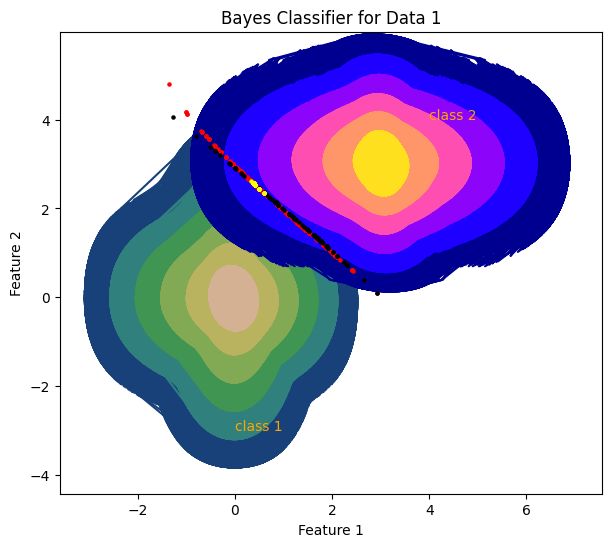

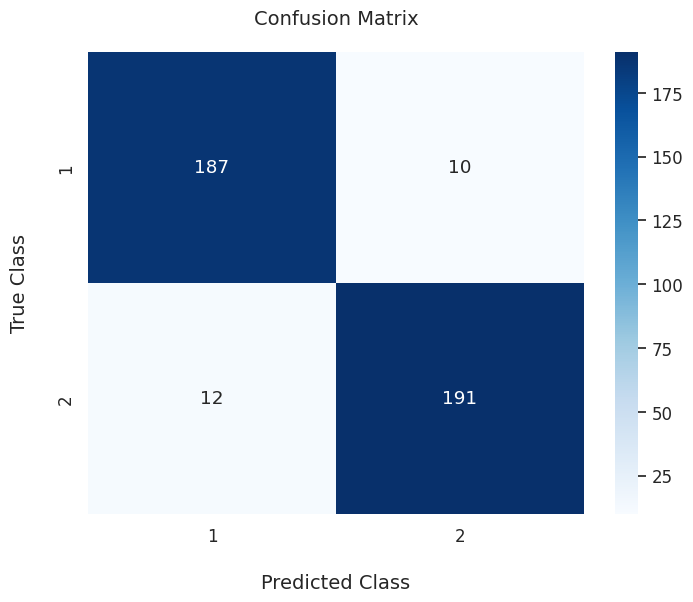

In [ ]:
#Dataset1
data1=pd.read_csv(r"/content/drive/MyDrive/PA2/dataset1.csv")
l=int(data1.shape[0]*0.8)
data1_train=data1[0:l]
data1_test=data1[l:]
#Dataset2
data2=pd.read_csv(r"/content/drive/MyDrive/PA2/dataset2.csv")
l=int(data2.shape[0]*0.8)
data2_train=data2[0:l]
data2_test=data2[l:]

#Dataset 1 Bayes Model 
#algo =1 for Bayes Model algo=2 for Naive Bayes ; setno.=1 for Dataset 1 and setno.=2 for Dataset2
new_mod=Classifier(data1_train,1,1,data1_test)
new_mod.model()
new_mod.contour_plt()
new_mod.Conf_Matrix()

Contour Plot Interpretation:
The contour plot is a representation of the 3 dimensional Joint Gaussian distribution in two dimensional plane.
The center most layer represents the highest probability. The contour plots are for likelihood function P(X|Y).
The overlapped area denotes the area where the features are same for both the classes.
The red line denotes the points for which class 1 has a posterior of=0.5.
That is, P(Y=1|X)=0.5 Whereas, P(Y=2|X)=0.5 is represented by the black line.
Decision boundary is denoted by yellow line in all the contour plot where P(Y=1|X)=P(Y=2|X)=0.5 and (X1,X2) of class 1= (X1,X2) of class2

We take 0.5 as the decision conditional probability because our classification problem is set as
if P(Y=1|X)> P(Y=2|X) then class=1
else if P(Y=1|X)< P(Y=2|X) then class=2
let P(Y=1|X)= a
then P(Y=2|X)= 1-a
such that P(Y=1|X)+P(Y+2|X)=1
if P(Y=1|X)=P(Y=2|X) then the data falls in decision boundary since we are unable to choose any class definitively.
Therefore, a=1-a
or, a=0.5
therefore P(Y=1|X)=P(Y=2|X)=0.5





 **In the above contour plot the red and the black line almost coincides but does not exactly coincide.Only the yellow points are those that coincides (they are those feature points of class 1 and 2 whose differences are less than 0.01).**


 Confusion Matrix:
The confusion matrix denotes the rightful and the missed clasfication by the Bayes Model for Dataset 1.
The first element in first row of the confusion matrix shows the number of data for class 1 which were correctly predicted. The second element in first row shows the number of data for class 1 which was wrongly classified as class 2. The first element in the second row shows the number of data for class 2 which were wrongly classified as class 1. The second element of second row shows the number of data in class 2 which were correctly classified as class 2.

The wrong classification made is either due to error in data itself or due to the elements being in boundary of two classes hence were randomly put into class 1 or 2 since there is no way of definitively predicting with this model which class they must belong.

**A separate side note on the choice made of approximating 0.5 to the interval (0.499,0.501) and the difference between (X1,X2) of class 1 and (X1,X2) of class 2 as less than 0.01 instead of 0.
If I had not taken an interval and instead equated them to zero, there would have been an empty set returned.
Whereas, if I did make the interval a bit larger eg, (0.49,0.51) and the other one (0,0.1) then the physical representation of the points on the contour map would have been quite visible. However, taking these intervals for test case caused a larger number of misclassification problems.
So, the choice of interval has been done to trade off between these 2 problems.**

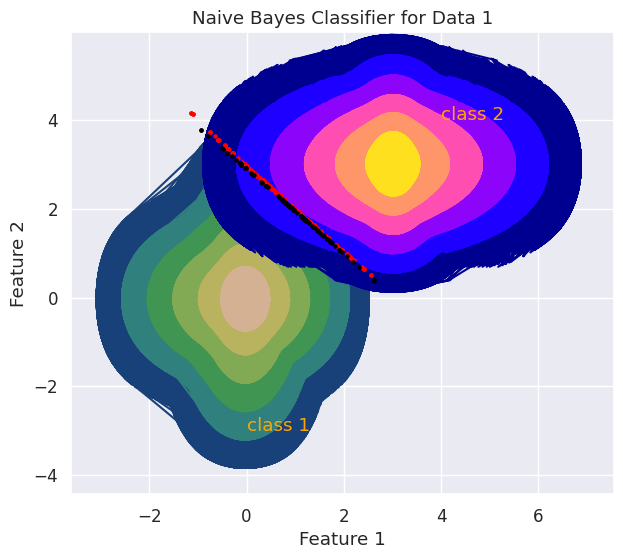

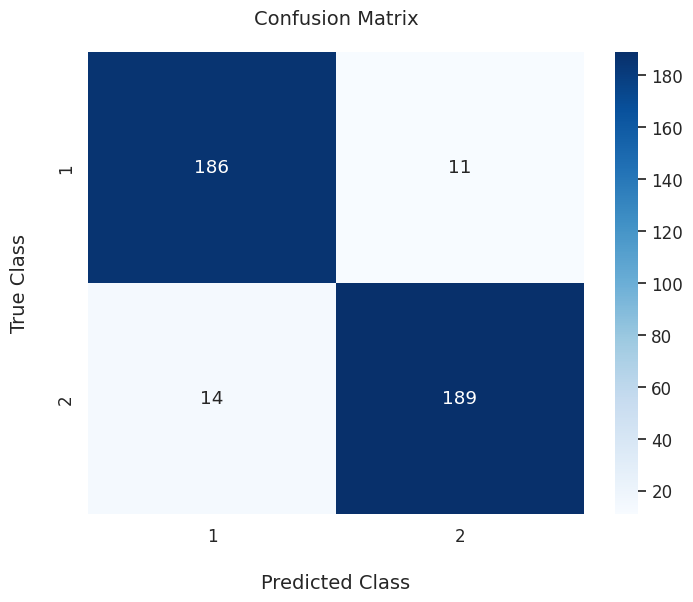

In [ ]:
#Dataset 1 Naive Bayes Model 
new_mod=Classifier(data1_train,2,1,data1_test)
new_mod.model()
new_mod.contour_plt()
new_mod.Conf_Matrix()


**In the above contour plot the red and the black line almost coincides but does not exactly coincide.There always exist a gap of greater than 0.01 thus there are no yellow points visible in the graph. But the decision boundary can be interpreted in that area where the black and the red line coincide.
However, the solution to the problem as stated above is framed such that the misclassification problem at the boundary region can be reduced. So even though to the human eye it seems the values are same at the black and red line area but there always exist a difference of greater than or equal to 0.01 between class 1 and class 2 features**

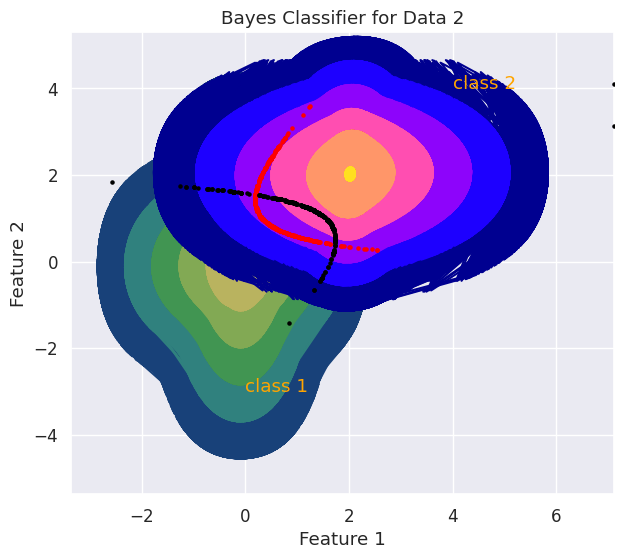

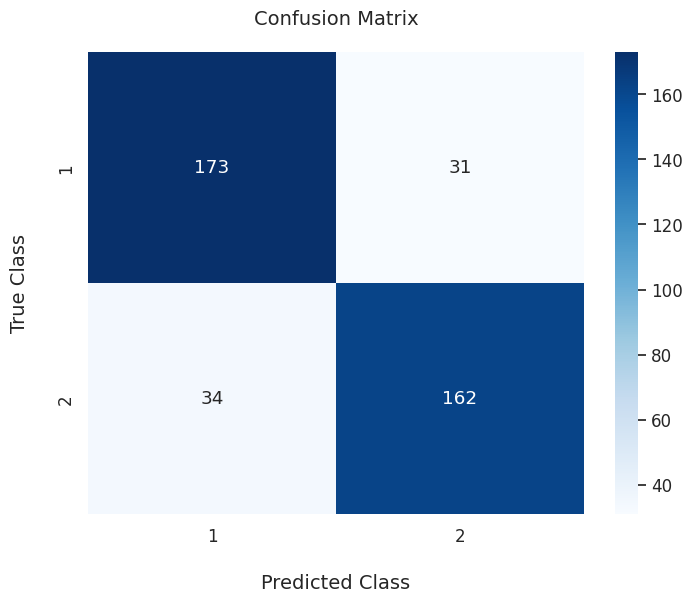

In [ ]:
#Dataset 2 Bayes Model 
new_mod=Classifier(data2_train,1,2,data2_test)
new_mod.model()
new_mod.contour_plt()
new_mod.Conf_Matrix()

 **In the above contour plot the red, the black and the yellow line do not coincide. Since even though the posterior function becomes 0.5 at the red (for class 1) curve and black (for class 2) curve but their (X1,X2) points do not match. In other words, the prior for class 1 and 2 become 0.5 together [for equal X1 and X2] for the intersection points of the curve. However, since training dataset had no points in those intersecting points thus, there are no yellow points**

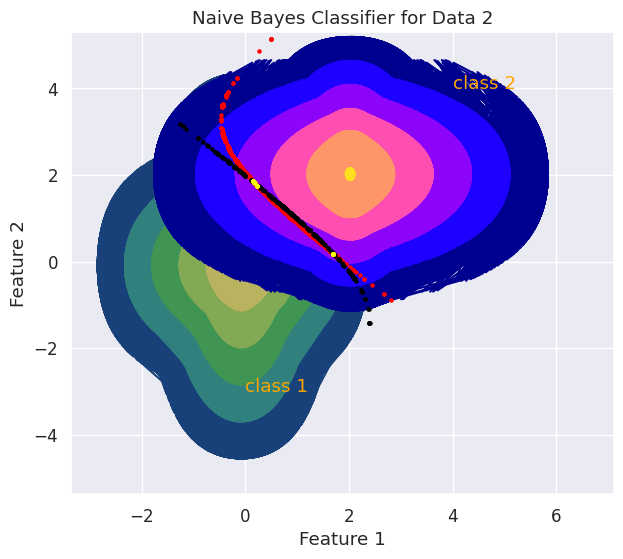

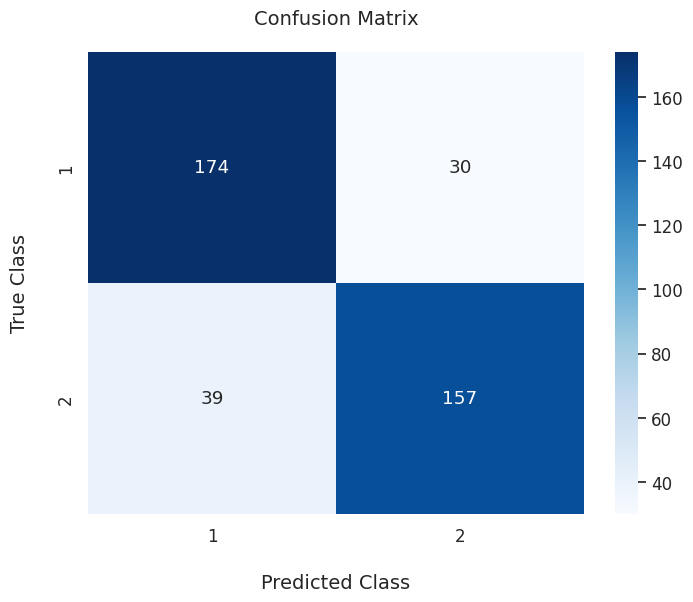

In [ ]:
#Dataset 1 Naive Bayes Model 
new_mod=Classifier(data2_train,2,2,data2_test)
new_mod.model()
new_mod.contour_plt()
new_mod.Conf_Matrix()

**In the above contour plot the red and the black line almost coincides but does not exactly coincide. The yellow points denote those points where features of class 1 and 2 coincide along with their posterior probability.**